 # Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Raw DataFrames

In [2]:
# global land temperature data by city, with latitude/longitude values
filename = 'Global-Land-Temperatures-By-City.csv'
temp_df = pd.read_csv(filename)

In [3]:
# US federal emergency data, join on county
filename1 = 'federal_emergencies.csv'
disaster_df = pd.read_csv(filename1)

In [4]:
# data of latitude/longitude and county to merge two dataframes
filename2 = 'zip_codes_states.csv'
us_join = pd.read_csv(filename2)

# Cleaning steps

In [5]:
# temp_df: drop all countries except US and drop NaN values
temp_us = temp_df[temp_df['Country'] == 'United States'].dropna()

In [6]:
# temp_df: create new lat/long columns dropping NESW direction
temp_us['lat_n'] = [float(lat[:-1]) if lat[-1]=='N' else -1*float(lat[:-1]) for lat in temp_us.loc[:,'Latitude']]
temp_us['lon_n'] = [float(lon[:-1]) if lon[-1]=='E' else -1*float(lon[:-1]) for lon in temp_us.loc[:,'Longitude']]

In [7]:
# unique coordinates in the temp_us dataframe
temp_us_coords = temp_us[['lat_n','lon_n']].drop_duplicates()

In [8]:
# function adds a column with pythagorean theorem 
def coord2loc(coords):
    us2 = us_join.copy()
    us2['dist'] = ((us2.latitude-coords.lat_n)**2+(us2.longitude-coords.lon_n)**2)**(1/2)
    state = us2.loc[us2.dist==min(us2.dist)]['state'].values[0]
    county = us2.loc[us2.dist==min(us2.dist)]['county'].values[0]
    return([coords.lat_n,coords.lon_n,state,county])

In [9]:
# create dataframe to join on between
join = pd.DataFrame([coord2loc(coords[1]) for coords in temp_us_coords.iterrows()])
join.columns = ['lat_n','lon_n','state','county']

In [10]:
# merge temp_df and us_join
temp_county = pd.merge(temp_us, join, how='left', on = ['lat_n', 'lon_n'])

In [11]:
# add "County" to the end of the county names to join on the disaster dataframe
temp_county['countyname'] = temp_county.county +' County'

In [12]:
temp_county['dt'] = pd.to_datetime(temp_county['dt'], format='%Y/%m/%d')
temp_county['year'] = temp_county['dt'].dt.year

In [13]:
temp_county.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,countyname,year
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820


In [14]:
# Extract month number for each row
temp_county_seasons = temp_county.copy()
temp_county_seasons['month'] = temp_county_seasons['dt'].dt.month

In [15]:
# Assign seasons to each date
temp_county_seasons['month'] = temp_county_seasons['month'].astype(str).astype(int)
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter', 
              3: 'Spring', 4: 'Spring', 5: 'Spring', 
              6: 'Summer', 7: 'Summer', 8: 'Summer', 
              9: 'Fall', 10: 'Fall', 11: 'Fall'}
def mapper(month):
    return season_map[month]
temp_county_seasons['season'] = temp_county_seasons['month'].apply(mapper)

In [16]:
# Assign United States common regions to the states
## Midwest Region
east_north_central_midwest_region = ['IL','IN','MI','OH','WI']
d1 = dict.fromkeys(east_north_central_midwest_region, 'east north central midwest region')

west_north_central_midwest_region = ['IA','KS','MO','MN','ND','SD','NE']
d2 = dict.fromkeys(west_north_central_midwest_region, 'west north central midwest region')

## Northeast Region
new_england_northeast_region = ['CT','ME','MA','NH','RI','VT']
d3 = dict.fromkeys(new_england_northeast_region, 'new england northeast region')

midatlantic_northeast_region = ['NY','PA','NJ']
d4 = dict.fromkeys(midatlantic_northeast_region, 'midatlantic northeast region')

## West Region
pacific_west_region = ['AK','OR','WA','CA','HI']
d5 = dict.fromkeys(pacific_west_region, 'pacific west region')

mountain_west_region = ['AZ','CO','NM','UT','NV','WY','ID','MT']
d6 = dict.fromkeys(mountain_west_region, 'mountain west region')

## South Region
west_south_central_south_region = ['AR','LA','OK','TX']
d7 = dict.fromkeys(west_south_central_south_region, 'west south central south region')

east_south_central_south_region = ['AL','MS','TN','KY']
d8 = dict.fromkeys(east_south_central_south_region, 'east south central south region')

south_atlantic_south_region = ['WV','MD','DC','DE','VA','NC','SC','GA','FL']
d9 = dict.fromkeys(south_atlantic_south_region, 'south atlantic south region')


In [17]:
temp_county_region = temp_county_seasons.copy()
d = {**d1, **d2, **d3, **d4, **d5, **d6, **d7, **d8, **d9}
temp_county_region['region'] = temp_county_region['state'].map(d)

In [18]:
temp_county_region['date_delta'] = (temp_county_region['dt'] - temp_county_region['dt'].min())  / np.timedelta64(1,'D')


In [19]:
temp_county_region.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,countyname,year,month,season,region,date_delta
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,1,Winter,west south central south region,27819.0
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,2,Winter,west south central south region,27850.0
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,3,Spring,west south central south region,27879.0
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,4,Spring,west south central south region,27910.0
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,5,Spring,west south central south region,27940.0


In [20]:
# copy of disaster data to organize for the join
disasterdf = disaster_df.copy()
disasterdf['Declaration Date'] = pd.to_datetime(disasterdf['Declaration Date'], format='%m/%d/%Y')
disasterdf['Year'] = disasterdf['Declaration Date'].dt.year
disasterdf = disasterdf[['Declaration Type','Declaration Date','State','County','Disaster Type','Year']]

In [21]:
disasterdf = disasterdf.drop_duplicates(subset=['Declaration Date','Disaster Type','State','Year']).sort_values('Declaration Date')
disasterdf.head()


,Declaration Type,Declaration Date,State,County,Disaster Type,Year
0,Disaster,1953-05-02,GA,NaN,Tornado,1953
1,Disaster,1953-05-15,TX,NaN,Tornado,1953
2,Disaster,1953-05-29,LA,NaN,Flood,1953
3,Disaster,1953-06-02,MI,NaN,Tornado,1953
4,Disaster,1953-06-06,MT,NaN,Flood,1953


In [22]:
# copy of temperature data to organize for the join
tempdf = temp_county_region.copy()
tempdf = tempdf.sort_values('dt')
tempdf.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,countyname,year,month,season,region,date_delta
365438,1743-11-01,10.572,2.352,Montgomery,United States,32.95N,87.13W,32.95,-87.13,AL,Bibb,Bibb County,1743,11,Fall,east south central south region,0.0
649026,1743-11-01,2.208,1.997,Windsor,United States,42.59N,82.91W,42.59,-82.91,MI,Macomb,Macomb County,1743,11,Fall,east north central midwest region,0.0
652167,1743-11-01,7.810,2.072,Winston Salem,United States,36.17N,79.56W,36.17,-79.56,NC,Guilford,Guilford County,1743,11,Fall,south atlantic south region,0.0
326790,1743-11-01,1.188,1.531,Lowell,United States,42.59N,72.00W,42.59,-72.00,MA,Worcester,Worcester County,1743,11,Fall,new england northeast region,0.0
127176,1743-11-01,10.375,2.313,Columbus,United States,32.95N,85.21W,32.95,-85.21,AL,Chambers,Chambers County,1743,11,Fall,east south central south region,0.0


In [23]:
# nearest join on date (with a left join on state first)
joindf = pd.merge_asof(disasterdf, tempdf, left_on='Declaration Date', right_on='dt',left_by='State',right_by='state',direction='nearest').dropna()


In [24]:
# removing rows where the join dates did not match since the disaster data only went up to Sept 2013
joindf = joindf[joindf['Declaration Date']<='2013-09-30']

In [25]:
joindf = joindf[['Disaster Type','Declaration Date','state','countyname','Year','month','season','region','date_delta','AverageTemperature']]


# Machine Learning

## Average yearly temperature, sorted by season

Text(0.5,1,'Fall')

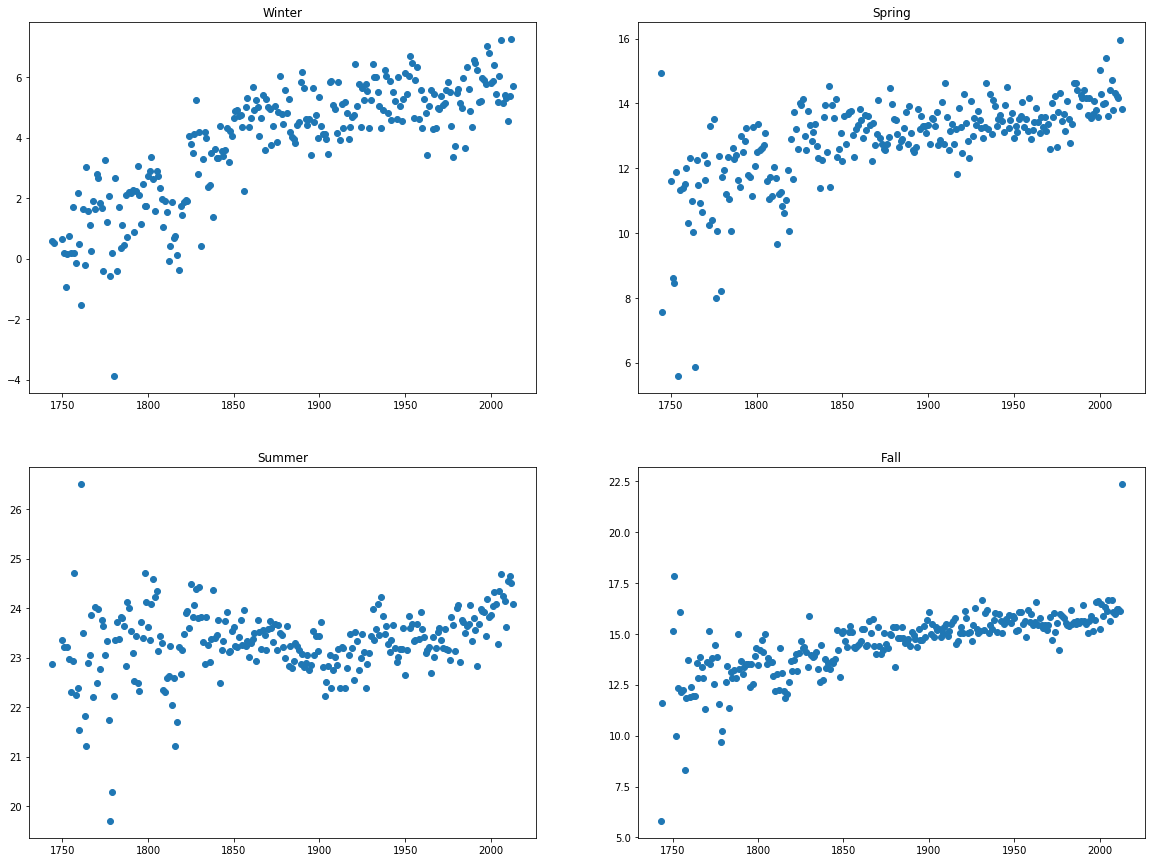

In [26]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

winter = temp_county_region[temp_county_region.season == 'Winter'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[0,0].scatter(winter['year'].tolist() ,winter['AverageTemperature'].tolist())
ax[0,0].set_title('Winter')           

spring = temp_county_region[temp_county_region.season == 'Spring'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[0,1].scatter(spring['year'].tolist() ,spring['AverageTemperature'].tolist())        
ax[0,1].set_title('Spring')

summer = temp_county_region[temp_county_region.season == 'Summer'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[1,0].scatter(summer['year'].tolist() ,summer['AverageTemperature'].tolist())
ax[1,0].set_title('Summer')

fall = temp_county_region[temp_county_region.season == 'Fall'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[1,1].scatter(fall['year'].tolist() ,fall['AverageTemperature'].tolist())
ax[1,1].set_title('Fall')           
                   
           

In [27]:
print('winter corr: ', winter['year'].corr(winter.AverageTemperature),'\n'
      'spring corr: ', spring['year'].corr(spring.AverageTemperature),'\n'
      'summer corr: ', summer['year'].corr(summer.AverageTemperature),'\n'
      'fall corr  : ', fall['year'].corr(fall.AverageTemperature))

winter corr:  0.8185691856309464 
spring corr:  0.6587791341045452 
summer corr:  0.24555088282850218 
fall corr  :  0.7381441619175758


### Winter Linear Regression - date delta

In [28]:
# scipy stats modeling 
x = winter[['year']].values
y = winter[['AverageTemperature']].values

In [29]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.020839    intercept: -35.340342    r-squared: 0.670056    p-value: 0.000000


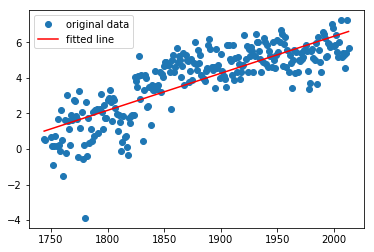

In [30]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

In [31]:
winter.year.corr(winter.AverageTemperature)

0.8185691856309464

### Random Train/Test Split

In [32]:
# train and test data for modeling
X = winter[['year']].values
y = winter[['AverageTemperature']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [33]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)
print(y_pred[0:5])

[[4.86123067]
 [3.53282078]
 [3.9613401 ]
 [5.61113948]
 [1.9472993 ]]


In [34]:
# Compute and print R^2 and RMSE
print("R^2 (Score): {}".format(lm.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print(lm.coef_, lm.intercept_)

R^2 (Score): 0.6163353103733953
Root Mean Squared Error: 1.1133479464089677
[[0.02142597]] [-36.46945771]


### Train on dates prior to 2011 and test on 2012

In [35]:
X_train = winter[winter['year']<=2011][['year']]
y_train = winter[winter['year']<=2011][['AverageTemperature']]

X_test = winter[winter['year']>2011][['year']]
y_test = winter[winter['year']>2011][['AverageTemperature']]

In [36]:
lm1 = linear_model.LinearRegression()
lm1.fit(X_train, y_train)

y_pred = lm1.predict(X_test)
print(y_pred, y_test)

[[6.5927321 ]
 [6.61359452]]      AverageTemperature
264            7.241545
265            5.698021


### Whole data set for modelling

In [37]:
# sklearn model on all of the data 
X = winter[['year']].values
y = winter[['AverageTemperature']].values

X = X.reshape(-1,1)
y = y.reshape(-1,1)

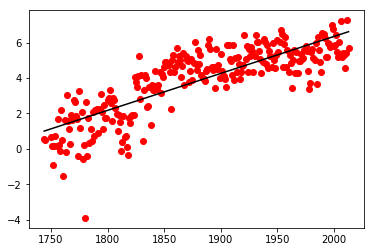

In [38]:
model = linear_model.LinearRegression()
model.fit(X, y)

plt.scatter(X, y,color='r')

plt.plot(X, model.predict(X),color='k')
plt.show()

In [39]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     [0.02083949]
Model intercept: [-35.34034165]


In [40]:
model.predict(2018)

array([[6.71375104]])

### Summer Linear Regression - year

In [41]:
# scipy stats modeling 
summer = temp_county_region[temp_county_region.season == 'Summer'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
x = summer[['year']].values
y = summer[['AverageTemperature']].values

In [42]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.002217    intercept: 19.151381    r-squared: 0.060295    p-value: 0.000055


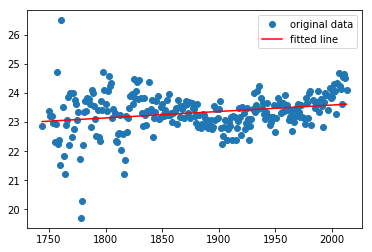

In [43]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

In [44]:
summer.year.corr(summer.AverageTemperature)

0.24555088282850218

## Average daily temperature, sorted by region

In [45]:
# nine regions of the United States
enc_midwest_region = temp_county_region[temp_county_region['region']=='east north central midwest region'].groupby('year').mean()[['AverageTemperature']].reset_index()

esc_south_region = temp_county_region[temp_county_region['region']=='east south central south region'].groupby('year').mean()[['AverageTemperature']].reset_index()

mid_northeast_region = temp_county_region[temp_county_region['region']=='midatlantic northeast region'].groupby('year').mean()[['AverageTemperature']].reset_index()

mt_west_region = temp_county_region[temp_county_region['region']=='mountain west region'].groupby('year').mean()[['AverageTemperature']].reset_index()

ne_northeast_region = temp_county_region[temp_county_region['region']=='new england northeast region'].groupby('year').mean()[['AverageTemperature']].reset_index()

pac_west_region = temp_county_region[temp_county_region['region']=='pacific west region'].groupby('year').mean()[['AverageTemperature']].reset_index()

sa_south_region = temp_county_region[temp_county_region['region']=='south atlantic south region'].groupby('year').mean()[['AverageTemperature']].reset_index()

wnc_midwest_region = temp_county_region[temp_county_region['region']=='west north central midwest region'].groupby('year').mean()[['AverageTemperature']].reset_index()

wsc_south_region = temp_county_region[temp_county_region['region']=='west south central south region'].groupby('year').mean()[['AverageTemperature']].reset_index()


In [46]:
print('enc corr: ', enc_midwest_region['year'].corr(enc_midwest_region.AverageTemperature),'\n'
      'esc corr: ', esc_south_region['year'].corr(esc_south_region.AverageTemperature),'\n'
      'mid corr: ', mid_northeast_region['year'].corr(mid_northeast_region.AverageTemperature),'\n'
      'mt corr: ', mt_west_region['year'].corr(mt_west_region.AverageTemperature),'\n'
      'ne corr: ', ne_northeast_region['year'].corr(ne_northeast_region.AverageTemperature),'\n'
      'pac corr: ', pac_west_region['year'].corr(pac_west_region.AverageTemperature),'\n'
      'sa corr: ', sa_south_region['year'].corr(sa_south_region.AverageTemperature),'\n'
      'wnc corr: ', wnc_midwest_region['year'].corr(wnc_midwest_region.AverageTemperature),'\n'
      'wsc corr: ', wsc_south_region['year'].corr(wsc_south_region.AverageTemperature),'\n')

enc corr:  0.4030379883249252 
esc corr:  0.43415441337079186 
mid corr:  0.48081285359265274 
mt corr:  0.6734878949707309 
ne corr:  0.49294117838291945 
pac corr:  0.6427530117788472 
sa corr:  0.5347502345372169 
wnc corr:  0.5768741511922301 
wsc corr:  0.5638639630474188 



These correlation values are moderately strong, and will potentially be explored if region-specific data is needed. Seeing that the regions have a positive medium-strong correlation with temperature over time in years, I can use the region divisions to model the predicted temperature in these regions and then use that model with the disaster that is likely to be found in that region and determine future information about the disaster data.

## Disaster data

Part of the hypothesis is to see if natural disasters in the United States have increased due to temperature changes. To examine the disaster side, I will look at the disaster data frame and see how disasters have changed over time. 

In [47]:
# count total number of disasters, see which disasters are most prevalent
disasterdf.groupby('Disaster Type').agg('count')['Declaration Type'].sort_values(ascending=False).head()

Disaster Type
Storm        919
Flood        772
Fire         680
Hurricane    313
Tornado      163
Name: Declaration Type, dtype: int64

The first five disasters with the most occurences in the United States are: storms, floods, fires, hurricanes, and tornados. I will focus on these disasters to examine the trends in the data, since they make up most of the data.

# Joined temperature and disaster data

In [48]:
joindf.head()

,Disaster Type,Declaration Date,state,countyname,Year,month,season,region,date_delta,AverageTemperature
89,Flood,1959-01-29,IN,Decatur County,1959,2.0,Winter,east north central midwest region,78619.0,0.961
181,Flood,1964-12-24,CA,San Diego County,1964,1.0,Winter,pacific west region,80780.0,13.677
182,Flood,1964-12-24,OR,Lane County,1964,1.0,Winter,pacific west region,80780.0,3.656
183,Flood,1964-12-29,WA,King County,1964,1.0,Winter,pacific west region,80780.0,1.133
185,Flood,1965-01-18,NV,Clark County,1965,2.0,Winter,mountain west region,80811.0,8.848


Text(0.5,1,'Average Yearly Temperature vs Disaster Count')

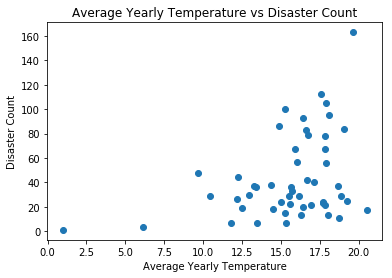

In [49]:
# average yearly temperature against disaster count 
joindf1 = joindf.groupby('Year').agg({'Disaster Type':'count',
                                                      'AverageTemperature':'mean'})

plt.scatter(joindf1['AverageTemperature'], joindf1['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs Disaster Count')

In [50]:
joindf1.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.363697
AverageTemperature,0.363697,1.000000


In [51]:
# linear regression 
x = joindf1[['AverageTemperature']].values
y = joindf1[['Disaster Type']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 3.601825    intercept: -12.736243    r-squared: 0.132275    p-value: 0.008705


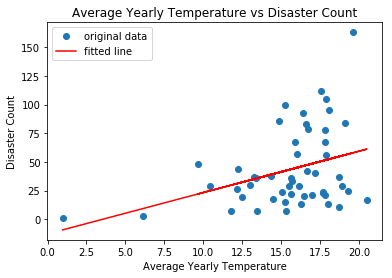

In [52]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs Disaster Count')
plt.show()

The p-value is statistically significant because it is less than a p-value of 0.05, and thus the null hypothesis that the slope is zero is rejected. 
 

## Random Forest

In [120]:
joindf['week'] = joindf['Declaration Date'].dt.week.astype('object')

In [121]:
joindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199 entries, 89 to 3108
Data columns (total 11 columns):
Disaster Type         2199 non-null object
Declaration Date      2199 non-null datetime64[ns]
state                 2199 non-null object
countyname            2199 non-null object
Year                  2199 non-null int64
month                 2199 non-null float64
season                2199 non-null object
region                2199 non-null object
date_delta            2199 non-null float64
AverageTemperature    2199 non-null float64
week                  2199 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 206.2+ KB


In [122]:
join_group = joindf.groupby(['Year','region','week']).agg({'Disaster Type':'count',
                                       'AverageTemperature':'mean'}).reset_index()

In [124]:
join_group['week'] = join_group['week'].astype('object')
join_group.rename(columns={'Disaster Type': 'Disaster Count'}, inplace=True)
join_group.head()

,Year,region,week,Disaster Count,AverageTemperature
0,1959,east north central midwest region,5,1,0.961000
1,1964,pacific west region,52,2,8.666500
2,1964,pacific west region,53,1,1.133000
3,1965,east north central midwest region,15,3,7.909667
4,1965,east north central midwest region,16,2,17.155500


In [125]:
# one-hot encode
join_group = pd.get_dummies(join_group)
join_group.head()

,Year,Disaster Count,AverageTemperature,region_east north central midwest region,region_east south central south region,region_midatlantic northeast region,region_mountain west region,region_new england northeast region,region_pacific west region,region_south atlantic south region,...,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_53
0,1959,1,0.961000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1964,2,8.666500,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,1964,1,1.133000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1965,3,7.909667,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1965,2,17.155500,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
# select labels
labels = np.array(join_group['Disaster Count'])
join_group = join_group.drop('Disaster Count', axis=1)
join_group_list = list(join_group.columns)
join_group = np.array(join_group)

In [127]:
train_features, test_features, train_labels, test_labels = train_test_split(join_group, labels, test_size = 0.3, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1215, 64)
Training Labels Shape: (1215,)
Testing Features Shape: (522, 64)
Testing Labels Shape: (522,)


In [128]:
rf1 = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf1.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [129]:
predictions = rf1.predict(test_features)

In [117]:
predictions

array([1.04, 1.48, 1.5 , 1.47, 1.01, 1.13, 1.11, 1.31, 1.06, 1.17, 1.09,
       1.28, 1.74, 1.04, 1.05, 1.37, 1.1 , 1.28, 1.25, 1.2 , 1.01, 1.03,
       1.09, 1.37, 1.11, 1.  , 1.43, 1.35, 1.21, 2.04, 1.04, 1.05, 1.03,
       1.  , 1.09, 1.11, 2.84, 1.04, 1.06, 1.5 , 1.  , 3.28, 1.06, 1.12,
       1.54, 1.09, 1.06, 1.08, 1.18, 1.23, 1.05, 1.02, 1.03, 1.55, 1.09,
       1.03, 2.74, 1.3 , 1.08, 1.71, 1.38, 1.68, 1.36, 3.05, 1.13, 1.09,
       1.02, 1.22, 1.56, 1.35, 1.46, 1.  , 1.02, 1.49, 1.05, 1.  , 1.18,
       1.03, 1.31, 1.51, 1.72, 1.  , 1.05, 1.19, 1.65, 1.04, 1.  , 1.05,
       1.01, 1.87, 1.  , 1.05, 1.23, 1.19, 1.18, 1.02, 1.11, 1.78, 1.12,
       1.07, 1.18, 1.32, 1.01, 1.32, 1.42, 1.42, 1.06, 1.  , 1.  , 1.56,
       1.04, 1.  , 1.4 , 1.42, 1.11, 1.44, 1.03, 1.16, 1.07, 1.04, 1.02,
       1.32, 1.12, 1.05, 1.22, 1.  , 1.02, 1.02, 1.18, 1.36, 1.03, 1.  ,
       1.02, 1.16, 1.02, 1.54, 1.69, 1.92, 1.15, 1.01, 2.81, 1.71, 1.3 ,
       1.1 , 1.01, 1.01, 1.08, 2.4 , 1.14, 1.27, 1.

Furthermore, I will look at the top five most occurring natural disasters and see if there is a strong enough correlation to potentially model on. I will go through the top five disasters (storms, floods, fires, hurricanes, and tornados) and their respective regions.

### Storms

Text(0,0.5,'Disaster Count')

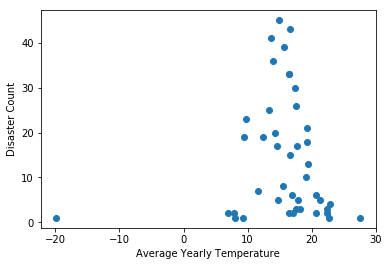

In [53]:
# storm count by year for all regions
stormdf = joindf[(joindf['Disaster Type']=='Storm')]
stormdf = stormdf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(stormdf['AverageTemperature'], stormdf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [54]:
stormdf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.00000,0.00977
AverageTemperature,0.00977,1.00000


In [55]:
# linear regression 
x = stormdf[['AverageTemperature']].values
y = stormdf[['Disaster Type']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.018704    intercept: 14.012312    r-squared: 0.000095    p-value: 0.950417


The p-value is large for average temperature vs disaster count by year, thus we cannot reject the null hypothesis. I will look at the top couple of regions containing the most number of storms to see if there is a stronger correlation.

In [56]:
# regional count of storms over time
joindf[joindf['Disaster Type']=='Storm']['region'].value_counts().head()

east south central south region      116
west north central midwest region    107
east north central midwest region     98
west south central south region       90
south atlantic south region           68
Name: region, dtype: int64

Text(0,0.5,'Disaster Count')

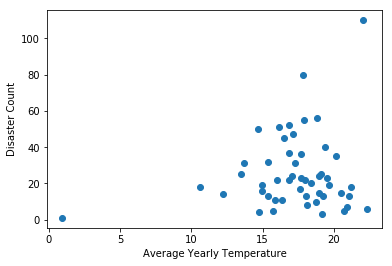

In [57]:
# storm count by year for top 5 regions with the most storms
stormdf = joindf[(joindf['Disaster Type']=='Storm')&
                 (joindf['region'].str.contains('east south central south region'))|
                 (joindf['region'].str.contains('west north central midwest region'))|
                 (joindf['region'].str.contains('east north central midwest region'))|
                 (joindf['region'].str.contains('west south central south region'))|
                 (joindf['region'].str.contains('south atlantic south region'))]
stormdf = stormdf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(stormdf['AverageTemperature'], stormdf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [58]:
stormdf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.171993
AverageTemperature,0.171993,1.000000


In [59]:
# linear regression 
x = stormdf[['AverageTemperature']].values
y = stormdf[['Disaster Type']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 1.045391    intercept: 7.828184    r-squared: 0.029582    p-value: 0.232345


The correlation and p-value are better when selecting the regions having the most number of storms, however, the p-value is still too large to reject the null hypothesis. Therefore, for the storm data, there is not a strong enough trend to perform a model on.

### Floods

Text(0,0.5,'Disaster Count')

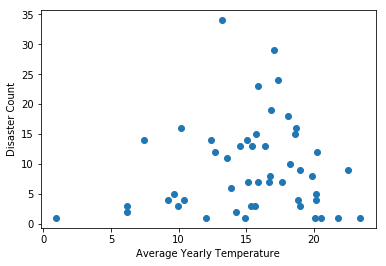

In [60]:
# flood count by year for all regions
flooddf = joindf[(joindf['Disaster Type']=='Flood')]
flooddf = flooddf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(flooddf['AverageTemperature'], flooddf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [61]:
flooddf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.065265
AverageTemperature,0.065265,1.000000


In [62]:
# linear regression 
x = flooddf[['AverageTemperature']].values
y = flooddf[['Disaster Type']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.108592    intercept: 7.614993    r-squared: 0.004260    p-value: 0.655932


In [63]:
# regional count of floods over time
joindf[joindf['Disaster Type']=='Flood']['region'].value_counts().head()

west south central south region      80
pacific west region                  73
west north central midwest region    67
east north central midwest region    59
mountain west region                 50
Name: region, dtype: int64

Text(0,0.5,'Disaster Count')

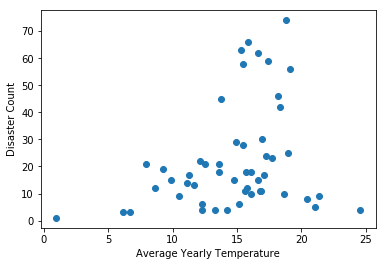

In [64]:
# flood count by year for top 5 regions with the most storms
flooddf = joindf[(joindf['Disaster Type']=='Storm')&
                 (joindf['region'].str.contains('west south central south region'))|
                 (joindf['region'].str.contains('pacific west region'))|
                 (joindf['region'].str.contains('west north central midwest region'))|
                 (joindf['region'].str.contains('east north central midwest region'))|
                 (joindf['region'].str.contains('mountain west region'))]
flooddf = flooddf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(flooddf['AverageTemperature'], flooddf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [65]:
flooddf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.283134
AverageTemperature,0.283134,1.000000


In [66]:
# linear regression 
x = flooddf[['AverageTemperature']].values
y = flooddf[['Disaster Type']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 1.273303    intercept: 3.559667    r-squared: 0.080165    p-value: 0.044088


I performed the same analysis, and when specifying the top regions of flooding, the p-value dropped to less than 0.05, which means that the null hypothesis can be rejected. Thus, a model can be used on the flood data.

### Fires

Text(0,0.5,'Disaster Count')

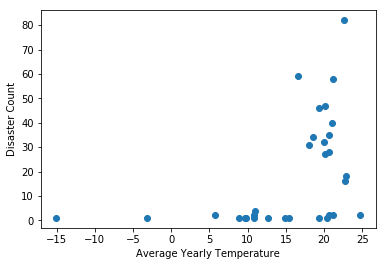

In [67]:
# fire count by year for all regions
firedf = joindf[(joindf['Disaster Type']=='Fire')]
firedf = firedf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(firedf['AverageTemperature'], firedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [68]:
firedf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.443328
AverageTemperature,0.443328,1.000000


In [69]:
# linear regression 
x = firedf[['AverageTemperature']].values
y = firedf[['Disaster Type']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 1.190244    intercept: 0.138441    r-squared: 0.196540    p-value: 0.012493


In [70]:
# regional count of fire over time
joindf[joindf['Disaster Type']=='Fire']['region'].value_counts().head()

pacific west region                174
mountain west region               170
west south central south region    151
south atlantic south region         57
east south central south region     12
Name: region, dtype: int64

Text(0,0.5,'Disaster Count')

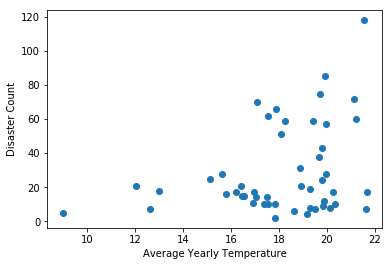

In [71]:
# fire count by year for top 5 regions with the most storms
firedf = joindf[(joindf['Disaster Type']=='Fire')&
                 (joindf['region'].str.contains('pacific west region'))|
                 (joindf['region'].str.contains('mountain west region'))|
                 (joindf['region'].str.contains('west south central south region'))|
                 (joindf['region'].str.contains('south atlantic south region'))|
                 (joindf['region'].str.contains('east south central south region'))]
firedf = firedf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(firedf['AverageTemperature'], firedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [72]:
firedf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.315015
AverageTemperature,0.315015,1.000000


In [73]:
# linear regression 
x = firedf[['AverageTemperature']].values
y = firedf[['Disaster Type']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 3.188525    intercept: -28.708773    r-squared: 0.099234    p-value: 0.027479


The fire data shows significant p-values using all regions and when selecting the top few regions. In addition to the flood data, the fire data can be used for future modeling.

### Hurricanes

Text(0,0.5,'Disaster Count')

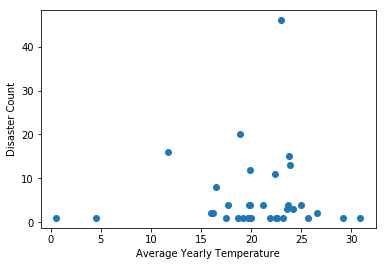

In [74]:
# hurricane count by year for all regions
hurricanedf = joindf[(joindf['Disaster Type']=='Hurricane')]
hurricanedf = hurricanedf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(hurricanedf['AverageTemperature'], hurricanedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [75]:
hurricanedf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.043427
AverageTemperature,0.043427,1.000000


In [76]:
# linear regression 
x = hurricanedf[['AverageTemperature']].values
y = hurricanedf[['Disaster Type']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.064047    intercept: 4.487914    r-squared: 0.001886    p-value: 0.810359


In [77]:
# regional count of hurricanes over time
joindf[joindf['Disaster Type']=='Hurricane']['region'].value_counts().head()

south atlantic south region        78
west south central south region    40
east south central south region    33
midatlantic northeast region       18
new england northeast region        8
Name: region, dtype: int64

Text(0,0.5,'Disaster Count')

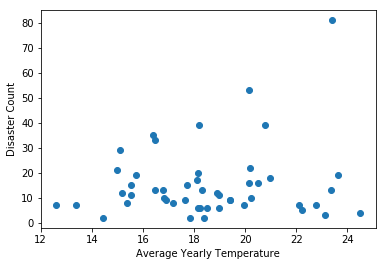

In [78]:
# hurricane count by year for top 3 regions with the most storms
hurricanedf = joindf[(joindf['Disaster Type']=='Hurricane')&
                 (joindf['region'].str.contains('south atlantic south region'))|
                 (joindf['region'].str.contains('west south central south region'))|
                 (joindf['region'].str.contains('east south central south region'))]
hurricanedf = hurricanedf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(hurricanedf['AverageTemperature'], hurricanedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [79]:
hurricanedf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.148129
AverageTemperature,0.148129,1.000000


In [80]:
# linear regression 
x = hurricanedf[['AverageTemperature']].values
y = hurricanedf[['Disaster Type']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.756013    intercept: 1.380308    r-squared: 0.021942    p-value: 0.309749


Hurricane data, similar to storm data, did not appear to have a strong correlation enough to have a low p-value. Thus, the null hypothesis cannot be rejected. 

### Tornados 

Text(0,0.5,'Disaster Count')

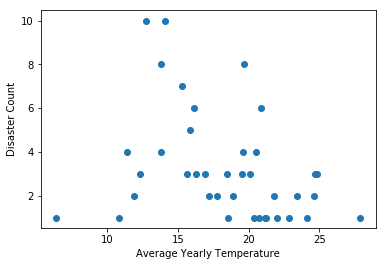

In [81]:
# tornado count by year for all regions
tornadodf = joindf[(joindf['Disaster Type']=='Tornado')]
tornadodf = tornadodf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(tornadodf['AverageTemperature'], tornadodf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [82]:
tornadodf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,-0.329665
AverageTemperature,-0.329665,1.000000


In [83]:
# linear regression 
x = tornadodf[['AverageTemperature']].values
y = tornadodf[['Disaster Type']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: -0.178398    intercept: 6.550155    r-squared: 0.108679    p-value: 0.040417


In [84]:
# regional count of tornados over time
joindf[joindf['Disaster Type']=='Tornado']['region'].value_counts().head()

west south central south region      39
east north central midwest region    28
east south central south region      24
south atlantic south region          17
west north central midwest region    16
Name: region, dtype: int64

Text(0,0.5,'Disaster Count')

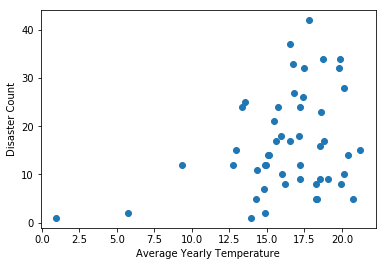

In [85]:
# tornado count by year for top 3 regions with the most storms
tornadodf = joindf[(joindf['Disaster Type']=='Tornado')&
                 (joindf['region'].str.contains('west south central south region'))|
                 (joindf['region'].str.contains('east north central midwest region'))|
                 (joindf['region'].str.contains('east south central south region'))|
                 (joindf['region'].str.contains('south atlantic south region'))]
tornadodf = tornadodf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(tornadodf['AverageTemperature'], tornadodf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [86]:
tornadodf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.00000,0.32204
AverageTemperature,0.32204,1.00000


In [87]:
# linear regression 
x = tornadodf[['AverageTemperature']].values
y = tornadodf[['Disaster Type']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.915712    intercept: 1.421531    r-squared: 0.103710    p-value: 0.022566


# TEST CODE RANDOM FOREST

# Temp data

In [88]:
bindf = temp_county_region.copy()
bindf.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,countyname,year,month,season,region,date_delta
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,1,Winter,west south central south region,27819.0
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,2,Winter,west south central south region,27850.0
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,3,Spring,west south central south region,27879.0
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,4,Spring,west south central south region,27910.0
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,5,Spring,west south central south region,27940.0


In [89]:
bindf = bindf[['date_delta','AverageTemperature','season','region']]

In [90]:
# one-hot encode
bindf = pd.get_dummies(bindf)
bindf.head()

,date_delta,AverageTemperature,season_Fall,season_Spring,season_Summer,season_Winter,region_east north central midwest region,region_east south central south region,region_midatlantic northeast region,region_mountain west region,region_new england northeast region,region_pacific west region,region_south atlantic south region,region_west north central midwest region,region_west south central south region
0,27819.0,2.101,0,0,0,1,0,0,0,0,0,0,0,0,1
1,27850.0,6.926,0,0,0,1,0,0,0,0,0,0,0,0,1
2,27879.0,10.767,0,1,0,0,0,0,0,0,0,0,0,0,1
3,27910.0,17.989,0,1,0,0,0,0,0,0,0,0,0,0,1
4,27940.0,21.809,0,1,0,0,0,0,0,0,0,0,0,0,1


In [91]:
labels = np.array(bindf['AverageTemperature'])
bindf = bindf.drop('AverageTemperature', axis=1)
bindf_list = list(bindf.columns)
bindf = np.array(bindf)

In [92]:
train_features, test_features, train_labels, test_labels = train_test_split(bindf, labels, test_size = 0.3, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (463066, 14)
Training Labels Shape: (463066,)
Testing Features Shape: (198458, 14)
Testing Labels Shape: (198458,)


In [93]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [94]:
predictions = rf.predict(test_features)

In [95]:
print(predictions, test_labels)

[20.94512113  6.79671551 17.56887172 ... 23.34699144 19.17696785
 15.82970565] [17.996  9.045 15.821 ... 23.15  19.254  8.453]


In [96]:
print(test_features)

[[5.0373e+04 1.0000e+00 0.0000e+00 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 [3.6220e+04 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [5.0708e+04 1.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [9.4141e+04 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [3.3449e+04 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.4509e+04 1.0000e+00 0.0000e+00 ... 1.0000e+00 0.0000e+00 0.0000e+00]]
